In [1]:
import numpy as np
import pickle
import galsim
import matplotlib.pyplot as plt

In [5]:
from main import SimCatVal
from utils import sample_position
position = sample_position(1, 67)
ra = position[0][0]
dec = position[0][1]
with open('psf_test.pkl', 'rb') as file:
    psf = pickle.load(file)
sample = {'n_images':139.0, 'sigma':2.3588755, 'psf':psf}
simp = {'i': sample}
print(simp)
afw_img, cat, truths, area = SimCatVal('/hildafs/home/pladuca/main/skyCatalog.yaml',ra,dec,1000,50,simp,31.4,True)

2026-01-06 03:11:55,563 - INFO - Catalog data will be read from /hildafs/home/pladuca/main/roman_rubin_cats_v1.1.2_faint/roman_rubin_cats_v1.1.2_faint/


{'i': {'n_images': 139.0, 'sigma': 2.3588755, 'psf': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)}}
Generating Sims


2026-01-06 03:11:56,802 - INFO - Working on healpix pixel 10307
2026-01-06 03:11:59,807 - INFO - Working on healpix pixel 10307


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4208 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

Running Pipeline


  0%|          | 0/1 [00:00<?, ?it/s]

Done!


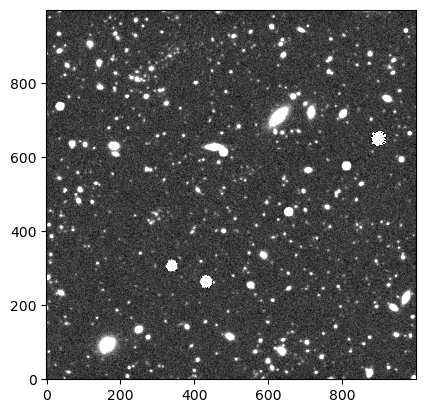

In [6]:
plt.imshow(afw_img['i'].image.array, origin='lower', cmap='gray', vmin=-3,vmax=10)

In [ ]:
#something strange is happening with the stars... could this be from the psf, maybe try simulating just a bright star to see

2026-01-07 17:32:43,605 - INFO - Catalog data will be read from /hildafs/home/pladuca/main/roman_rubin_cats_v1.1.2_faint/roman_rubin_cats_v1.1.2_faint/


2026-01-07 17:32:44,743 - INFO - Working on healpix pixel 10307
2026-01-07 17:32:48,038 - INFO - Working on healpix pixel 10307


3693
galsim.Image(bounds=galsim.BoundsI(1,1000,1,1000), wcs=galsim.GSFitsWCS(_data = ['TAN', array([500.0, 500.0]), array([[-5.5555555555555565e-05, -0.0], [0.0, 5.5555555555555565e-05]]), coord.CelestialCoord(coord.Angle(0.1822110231465979, coord.radians), coord.Angle(-0.7466483263415326, coord.radians)), None, None, None]), dtype=numpy.float32)


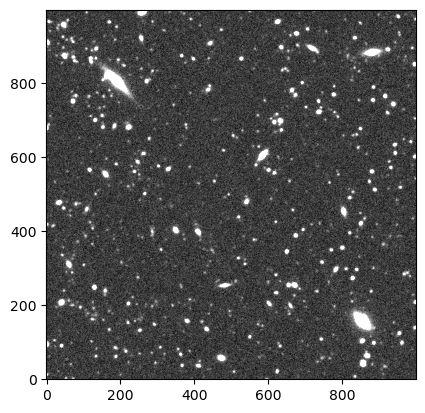

In [ ]:
import numpy as np
import pickle
import galsim
import matplotlib.pyplot as plt
from utils import get_wcs, get_psf, get_noise
from skycat import SkyCat
from utils import sample_position

position = sample_position(1, 67)
ra = position[0][0]
dec = position[0][1] + 22 * 0.0055
with open('psf_test.pkl', 'rb') as file:
    psf = pickle.load(file)
sample = {'n_images':139.0, 'sigma':2.3588755, 'psf':psf}
simp = {'i': sample}

size = 1000

pointing = galsim.CelestialCoord(ra=ra * galsim.degrees,dec=dec * galsim.degrees)
wcs = get_wcs(size, pointing)
skycat = SkyCat('/hildafs/home/pladuca/main/skyCatalog.yaml', pointing, size, 25, wcs)
psf_fwhm = simp['i']['psf']
sigma = simp['i']['sigma']
nim = simp['i']['n_images']
psf = get_psf(psf_fwhm)
noise_img = galsim.Image(size, size, wcs=wcs)
rng_galsim = galsim.BaseDeviate()
noise = get_noise(rng_galsim, sigma)
noise_img.addNoise(noise)
final_img = galsim.Image(size, size, wcs=wcs)
t = 'star'
print(skycat.get_n(t))
for g in range(skycat.get_n(t)):
    gal, dx, dy, obj_info= skycat.get_obj(t, g, 'i', 31.4)

    obj = galsim.Convolve(gal, psf)
    world_pos = pointing.deproject(dx * galsim.arcsec, dy * galsim.arcsec,)
    image_pos = wcs.toImage(world_pos)
    n_photons = galsim.PoissonDeviate(rng_galsim, mean=gal.flux)()
    
    if n_photons >= 5e5:
        print(n_photons)
        # n_photons = 1e6
        stamp_size = 250
        if n_photons >= 1e8:
            n_photons = 1e8
            stamp_size = 600

        stamp = obj.drawImage(
            nx=stamp_size,
            ny=stamp_size,
            bandpass=skycat.bands['i'], 
            wcs=wcs.local(world_pos=world_pos), 
            method='phot',
            n_photons=n_photons,
            maxN=int(1e7),
            rng=rng_galsim)
        stamp.setCenter(image_pos.x, image_pos.y)

    else:
        n_photons = n_photons * nim #for correct poisson noise
        if n_photons >= 1e8:
            n_photons = 1e8

        stamp = obj.drawImage(
            # nx=stamp_size, # this auto chooses a size
            # ny=stamp_size,
            bandpass=skycat.bands['i'], 
            wcs=wcs.local(world_pos=world_pos), 
            method='phot',
            n_photons=n_photons,
            maxN=int(1e7),
            rng=rng_galsim)
        stamp.setCenter(image_pos.x, image_pos.y)
        
    b = stamp.bounds & final_img.bounds
    if b.isDefined():
        final_img[b] += stamp[b]

final_img += noise_img

print(final_img)
plt.imshow(final_img.array, origin='lower', cmap='gray', vmin=-3,vmax=10)

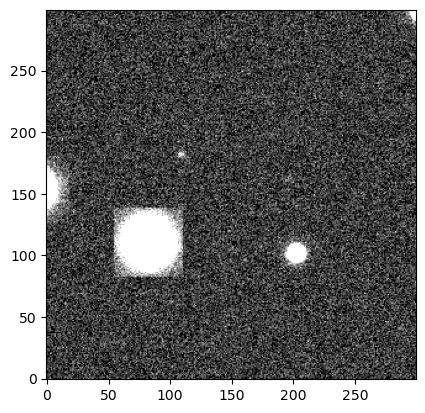

In [7]:
plt.imshow(final_img.array, origin='lower', cmap='gray', vmin=-3,vmax=10)

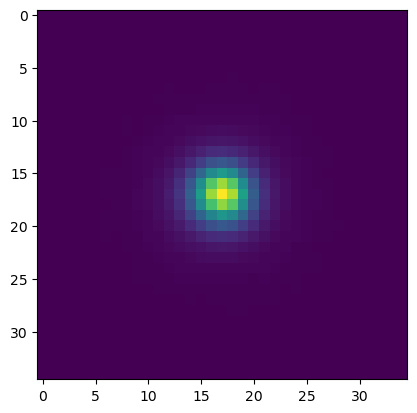

In [3]:
with open('psf_test.pkl', 'rb') as file:
    psf = pickle.load(file)
plt.imshow(psf)

(13.0, 28.0)

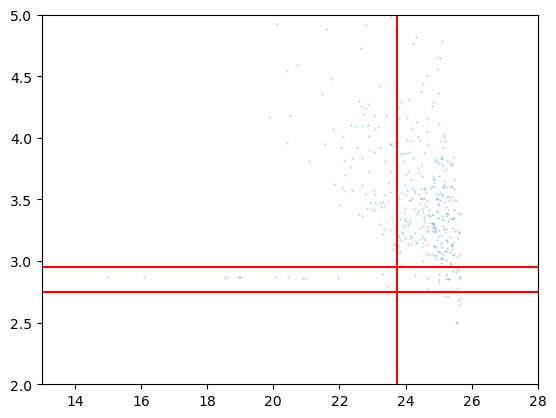

In [7]:
b = 'i'
temp = cat[b]
temp = temp[(temp['deblend_nChild'] == 0) &
    (temp['base_SdssShape_flag'] == False) &
    (temp['modelfit_CModel_instFlux'] >= 0) &
    (temp['modelfit_CModel_flag'] == False) &
    (temp['ext_gaap_GaapFlux_1_15x_Optimal_instFlux'] >= 0) &
    (temp['base_SdssCentroid_flag'] == False) &
    (temp['ext_gaap_GaapFlux_flag'] == False) &
    (temp['base_ClassificationSizeExtendedness_flag'] == False)]
temp = temp[(temp['base_PsfFlux_instFlux']/temp['base_PsfFlux_instFluxErr'] >= 10)]

mag = -2.5 * np.log10(temp['modelfit_CModel_instFlux']) + 31.4
size = np.sqrt(temp['base_SdssShape_xx'] + temp['base_SdssShape_yy'])

plt.scatter(mag, size, s=0.3, alpha=0.3)
# plt.scatter(mag, psf, s=0.3, alpha=0.3)
plt.axhline(2.95, c='r')
plt.axhline(2.75, c='r')
plt.axvline(23.75, c='r')
plt.ylim(2,5)
plt.xlim(13,28)

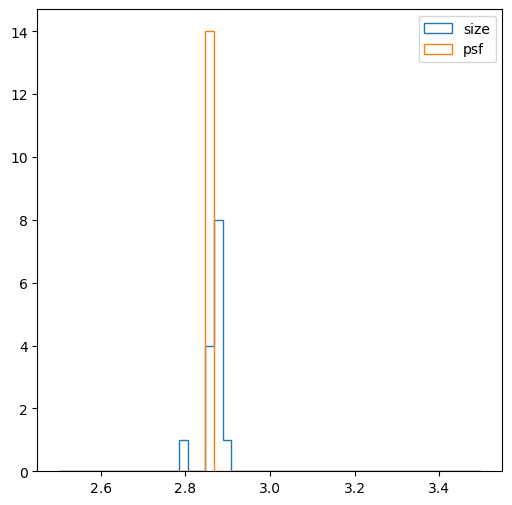

In [8]:
stars = temp[(mag < 23.75) & (size < 2.95) & (size > 2.75)]

size_bins = np.linspace(2.5,3.5,50)
star_size = np.sqrt(stars['base_SdssShape_xx'] + stars['base_SdssShape_yy'])
star_psf = np.sqrt(stars['base_SdssShape_psf_xx'] + stars['base_SdssShape_psf_yy'])
fig, ax = plt.subplots(figsize=(6,6))
plt.hist(star_size, size_bins, histtype="step", label="size")
plt.hist(star_psf, size_bins, histtype="step", label="psf")
plt.legend()
plt.show()

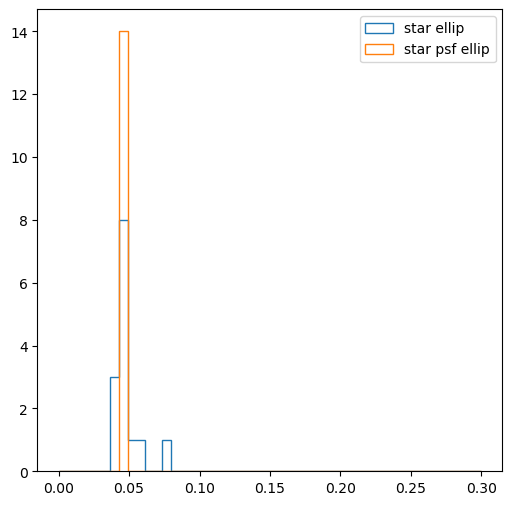

In [9]:
e1 = (stars['base_SdssShape_psf_xx'] - stars['base_SdssShape_psf_yy'])/(stars['base_SdssShape_psf_xx'] + stars['base_SdssShape_psf_yy'])
e2 = 2*(stars['base_SdssShape_psf_xy'])/(stars['base_SdssShape_psf_xx'] + stars['base_SdssShape_psf_yy'])
ellip = np.sqrt((e1)**2 + (e2)**2)

se1 = (stars['base_SdssShape_xx'] - stars['base_SdssShape_yy'])/(stars['base_SdssShape_xx'] + stars['base_SdssShape_yy'])
se2 = 2*(stars['base_SdssShape_xy'])/(stars['base_SdssShape_xx'] + stars['base_SdssShape_yy'])
sellip = np.sqrt((se1)**2 + (se2)**2)

ellip_bins = np.linspace(0,0.3,50)
fig, ax = plt.subplots(figsize=(6,6))
plt.hist(sellip, ellip_bins, histtype="step", label="star ellip")
plt.hist(ellip, ellip_bins, histtype="step", label="star psf ellip")
plt.legend()
plt.show()

# approx zero, consistent with kolmogorov profile

In [3]:
with open('psf_test.pkl', 'rb') as file:
    psf = pickle.load(file)

print(psf)
print(psf.shape)
padded = np.pad(psf,35,mode='constant')
print(padded)
print(padded.shape)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(35, 35)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(105, 105)


In [4]:
ipsf = galsim.Image(psf)
gpsf = galsim.InterpolatedImage(ipsf, scale=0.2, normalization='flux')
print(gpsf)
print(gpsf.calculateMomentRadius()/0.2) #why is this slightly smaller than measued value from DP1?
print(gpsf.calculateFWHM()/0.2)
pixel = galsim.Pixel(0.2)
epsf = galsim.Convolve(pixel, gpsf)
print(epsf.calculateFWHM()/0.2)

galsim.InterpolatedImage(image=galsim.Image(bounds=galsim.BoundsI(-17,17,-17,17), scale=0.2, dtype=numpy.float64), flux=0.99999999611243)
2.7716448140692163
4.156009037928731
4.225404329113469


In [5]:
ipsf = galsim.Image(padded)
gpsf = galsim.InterpolatedImage(ipsf, scale=0.2, normalization='flux')
print(gpsf)
print(gpsf.calculateMomentRadius()/0.2) #why is this slightly smaller than measued value from DP1?
print(gpsf.calculateFWHM()/0.2)
pixel = galsim.Pixel(0.2)
epsf = galsim.Convolve(pixel, gpsf)
print(epsf.calculateFWHM()/0.2)

galsim.InterpolatedImage(image=galsim.Image(bounds=galsim.BoundsI(-52,52,-52,52), scale=0.2, dtype=numpy.float64), flux=0.9999999961124298)
2.7736830785727387
4.16287637229821
4.231749138891561


In [6]:
dpsf = galsim.InterpolatedImage(ipsf, scale=0.2, depixelize=True, normalization='flux') #this can account for pixel response, does it affect ellipticity?
print(dpsf.calculateFWHM()/0.2)
pixel = galsim.Pixel(0.2)
epsf = galsim.Convolve(pixel, dpsf)
print(epsf.calculateFWHM()/0.2)

4.097073766848469
4.1671210675523245


In [7]:
fwhm = 4.156009037928731 * 0.2 #convert pixels to arcsec
psf = galsim.Kolmogorov(fwhm=fwhm, scale_unit=galsim.arcsec)
print(psf.calculateFWHM()/0.2)
pixel = galsim.Pixel(0.2)
epsf = galsim.Convolve(pixel, psf)
print(epsf.calculateFWHM()/0.2)

4.156009037928731
4.224631193694715


In [ ]:
#shapelet fit to the psf model? https://community.lsst.org/t/how-to-compute-psf-image-kernel-image-without-background-noise/1713

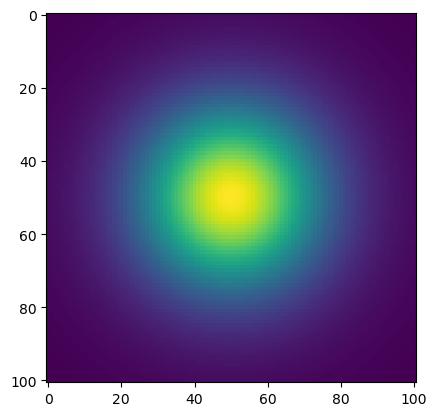

In [26]:
fwhm = 4.156009037928731 *0.2#convert pixels to arcsec
psf = galsim.Kolmogorov(fwhm=fwhm, scale_unit=galsim.arcsec)
psf = psf.drawImage(nx=101, ny=101, scale=0.2/10, method='no_pixel')
plt.imshow(psf.array)

In [27]:
psf = galsim.InterpolatedImage(psf, scale=0.2/10, depixelize=True, normalization='flux', x_interpolant=galsim.Lanczos(5))
pixel = galsim.Pixel(0.2)
epsf = galsim.Convolve(pixel, psf)
print(epsf.calculateFWHM()/0.2)

4.222860268377009
